In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
IMG_PATH = "cat_dog.png"
IMG_SIZE = (224, 224)
LAST_CONV_LAYER = "block5_conv3"
CLASSIFIER_LAYER_NAMES = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions",
]

In [3]:
model_builder = keras.applications.vgg16.VGG16
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

In [4]:
# model_builder = keras.applications.xception.Xception
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

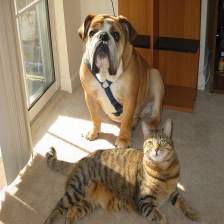

In [5]:
last_conv_layer_name = LAST_CONV_LAYER
classifier_layer_names = CLASSIFIER_LAYER_NAMES
image_size = IMG_SIZE
# img_path = keras.utils.get_file("cat_dog.png", "./cat_dog.png")
display(Image(IMG_PATH))

In [16]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names
):
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]
        
    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is the vector where each entry is the mean intensity of the 
    # gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how importat this channels is" with regards to 
    # the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # For visualization, normalize the heatmap between [0, 1]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap
        

## Prepare Image

In [17]:
img_array = get_img_array(IMG_PATH, size=image_size)
print(img_array.shape)
img_array = preprocess_input(img_array)
model = model_builder(weights="imagenet")
preds = model.predict(img_array)
print(f"Predicted: {decode_predictions(preds, top=1)[0]}")

(1, 224, 224, 3)
Predicted: [('n02108089', 'boxer', 0.4201405)]


In [18]:
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
#plt.matshow(heatmap)
#plt.show()
print(heatmap.shape)

tf.Tensor(242, shape=(), dtype=int64)
(14, 14)


In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
img = keras.preprocessing.image.load_img(IMG_PATH)
img = keras.preprocessing.image.img_to_array(img)

In [11]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

In [12]:
# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [13]:
new_img = tf.cast(tf.math.add(tf.math.multiply(jet_heatmap, 0.4), img), tf.uint8)

In [ ]:
super_img = tf.image.encode_jpeg(new_img)
save_path = "cat_dog_cam.jpg"


In [ ]:
# superimposed_img = keras.preprocessing.image.array_to_img(new_img)

save_path = "cat_dog_cam.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

In [15]:
cv2.imwrite("super_img.jpg", np.array(new_img))


True

In [ ]:
np.min(new_img)

In [ ]:
224 * 224

In [ ]:
14 * 14 * 512

In [ ]:
def overlay_heatmap(heatmap, image, alpha=0.5, color_map=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, color_map)
    output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

    
    return output, heatmap

In [ ]:
heatmap = np.uint8(255 * heatmap)
out, heatmap = overlay_heatmap(heatmap, img)

In [ ]:
jet_heatmap